<cell_type>markdown</cell_type># 2D Plane Strain FEA — CalculiX

Industrial-grade FEA verification of the CCS bistable **half-beam** using
CalculiX (ccx) with `NLGEOM` for geometrically nonlinear analysis.

**Boundary conditions**:
- Anchor (x≈0): clamped, u_x = u_y = 0
- Shuttle (x≈L): prescribe u_y, u_x free

**Workflow**: Generate mesh with `triangle` → write CalculiX `.inp` file →
run `ccx` as subprocess → parse reaction forces from `.dat` output.

In [1]:
import sys
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import triangle as tr
import re
import shutil

sys.path.insert(0, os.path.dirname(os.path.abspath("__file__")))
from beam_utils import (
    POLY_SI, DEFAULT_BEAM_PARAMS, get_beam_polygon,
    get_beam_centerline,
)

L = DEFAULT_BEAM_PARAMS["half_span"]   # 20 µm
h = DEFAULT_BEAM_PARAMS["initial_offset"]  # 1.2 µm
t = POLY_SI["t"]
E = POLY_SI["E"]
nu = POLY_SI["nu"]

# Find ccx executable
CCX = shutil.which('ccx')
if CCX is None:
    CCX = os.path.abspath('../../switch-env/bin/ccx')
print(f"CalculiX: {CCX}")
result = subprocess.run([CCX, '-v'], capture_output=True, text=True)
print(result.stdout.strip())
print(f"Half-beam: L={L} µm, h={h} µm, t={t} µm")

# Working directory for CalculiX files
CCX_DIR = os.path.abspath('results/ccx_2d')
os.makedirs(CCX_DIR, exist_ok=True)

CalculiX: /Users/neekon/git/mcw/mcw-mems-photonic-switch/switch-env/bin/ccx
This is Version 2.23
Half-beam: L=20.0 µm, h=1.2 µm, t=0.5 µm


## 1. Mesh Generation

Mesh: 2505 nodes, 4198 triangles


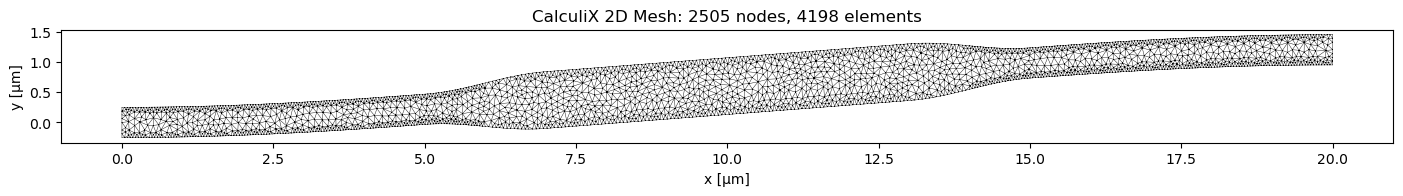

In [2]:
# Same mesh generation as scikit-fem 2D
poly = get_beam_polygon(n_points=400)
if np.allclose(poly[0], poly[-1]):
    poly = poly[:-1]

n_verts = len(poly)
segments = np.column_stack([np.arange(n_verts), (np.arange(n_verts) + 1) % n_verts])

tri_input = {'vertices': poly, 'segments': segments}
max_area = 0.008
tri_out = tr.triangulate(tri_input, f'pq30a{max_area}')

nodes = tri_out['vertices']
elems = tri_out['triangles']
print(f"Mesh: {len(nodes)} nodes, {len(elems)} triangles")

# Visualize
fig, ax = plt.subplots(figsize=(14, 4))
ax.triplot(nodes[:, 0], nodes[:, 1], elems, 'k-', linewidth=0.3)
ax.set_aspect('equal')
ax.set_title(f'CalculiX 2D Mesh: {len(nodes)} nodes, {len(elems)} elements')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
fig.tight_layout()
fig.savefig('plots/calculix_2d_mesh.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Identify Boundary Node Sets

In [3]:
tol = 0.05

# Anchor nodes (x ≈ 0): fully clamped
anchor_nids = np.where(nodes[:, 0] < tol)[0] + 1  # CalculiX is 1-indexed

# Shuttle nodes (x ≈ L): prescribe y-displacement
shuttle_nids = np.where(nodes[:, 0] > L - tol)[0] + 1

print(f"Anchor nodes: {len(anchor_nids)}")
print(f"Shuttle nodes: {len(shuttle_nids)}")

Anchor nodes: 10
Shuttle nodes: 10


## 3. Write CalculiX Input File

In [4]:
def write_ccx_input(filepath, nodes, elems, anchor_nids, shuttle_nids,
                     delta, E, nu, thickness):
    """Write CalculiX .inp file for 2D plane strain half-beam analysis.
    
    BCs: anchor clamped (u_x=u_y=0), shuttle y-prescribed (u_x free).
    Uses CPE3 (3-node plane strain triangle) elements.
    """
    with open(filepath, 'w') as f:
        f.write('*HEADING\n')
        f.write('CCS Bistable Half-Beam - 2D Plane Strain\n')
        f.write('**\n')
        
        # Nodes
        f.write('*NODE\n')
        for i, (x, y) in enumerate(nodes):
            f.write(f'{i+1}, {x:.8f}, {y:.8f}, 0.0\n')
        
        # Elements (CPE3 = 3-node plane strain triangle)
        f.write('*ELEMENT, TYPE=CPE3, ELSET=BEAM\n')
        for i, (n1, n2, n3) in enumerate(elems):
            f.write(f'{i+1}, {n1+1}, {n2+1}, {n3+1}\n')
        
        # Node sets
        f.write('*NSET, NSET=ANCHOR\n')
        for j, nid in enumerate(anchor_nids):
            f.write(f'{nid}')
            if (j + 1) % 16 == 0 or j == len(anchor_nids) - 1:
                f.write('\n')
            else:
                f.write(', ')
        
        f.write('*NSET, NSET=SHUTTLE\n')
        for j, nid in enumerate(shuttle_nids):
            f.write(f'{nid}')
            if (j + 1) % 16 == 0 or j == len(shuttle_nids) - 1:
                f.write('\n')
            else:
                f.write(', ')
        
        # Material
        f.write('*MATERIAL, NAME=POLYSI\n')
        f.write('*ELASTIC\n')
        f.write(f'{E:.1f}, {nu:.4f}\n')
        
        # Section (plane strain, with thickness)
        f.write('*SOLID SECTION, ELSET=BEAM, MATERIAL=POLYSI\n')
        f.write(f'{thickness:.4f}\n')
        
        # Step with geometric nonlinearity
        f.write('*STEP, NLGEOM, INC=1000\n')
        f.write('*STATIC\n')
        f.write('0.05, 1.0, 1e-8, 0.2\n')
        
        # Boundary conditions
        # Anchor: clamp u_x = u_y = 0
        f.write('*BOUNDARY\n')
        f.write('ANCHOR, 1, 2, 0.0\n')
        
        # Shuttle: prescribe y-displacement only (DOF 2)
        f.write('*BOUNDARY\n')
        f.write(f'SHUTTLE, 2, 2, {delta:.8f}\n')
        
        # Output
        f.write('*NODE FILE\n')
        f.write('U, RF\n')
        
        f.write('*NODE PRINT, NSET=SHUTTLE, TOTALS=YES\n')
        f.write('RF\n')
        
        f.write('*END STEP\n')

# Test: write one input file
test_inp = os.path.join(CCX_DIR, 'test.inp')
write_ccx_input(test_inp, nodes, elems, anchor_nids, shuttle_nids,
                -h, E, nu, t)
print(f"Test input written: {test_inp}")

Test input written: /Users/neekon/git/mcw/mcw-mems-photonic-switch/src/verification/results/ccx_2d/test.inp


In [5]:
# Test run
job_name = 'test'
result = subprocess.run(
    [CCX, '-i', job_name],
    cwd=CCX_DIR,
    capture_output=True, text=True, timeout=120
)
print("stdout:", result.stdout[-500:] if len(result.stdout) > 500 else result.stdout)
if result.returncode != 0:
    print("stderr:", result.stderr[-500:])

stdout: = 0.363054
 time avg. forc= 0.162759
 largest residual force= 0.000000 in node 1007 and dof 1
 largest increment of disp= 1.722808e-01
 largest correction to disp= 7.077319e-06 in node 930 and dof 2

 convergence; the increment size is increased to 2.156250e-01

 the increment size exceeds the maximum allowed and is decreased to 2.000000e-01

 the increment size exceeds the remainder of the step and is decreased to 0.000000e+00

 Using up to 1 cpu(s) for the stress calculation.


 Job finished




## 4. Parse CalculiX Output

In [6]:
def parse_ccx_reaction_force(dat_file):
    """Parse total reaction force from CalculiX .dat file.
    
    The .dat format has:
      total force (fx,fy,fz) for set SHUTTLE and time  X.XXX
      
             fx_value  fy_value  fz_value
    
    Returns fy from the LAST total force entry (final converged increment).
    """
    with open(dat_file, 'r') as f:
        lines = f.readlines()
    
    rf_y = None
    for i, line in enumerate(lines):
        if 'total force' in line.lower():
            # Values are on the next non-empty line
            for j in range(i + 1, min(i + 5, len(lines))):
                parts = lines[j].split()
                if len(parts) >= 2:
                    try:
                        rf_y = float(parts[1])  # fy is second column
                        break
                    except ValueError:
                        continue
    
    return rf_y

# Test parse
dat_file = os.path.join(CCX_DIR, 'test.dat')
if os.path.exists(dat_file):
    rf_y = parse_ccx_reaction_force(dat_file)
    print(f"Test: RF_y = {rf_y} µN at δ = {-h} µm")
else:
    # Run ccx first
    result = subprocess.run([CCX, '-i', 'test'], cwd=CCX_DIR,
                           capture_output=True, text=True, timeout=120)
    dat_file = os.path.join(CCX_DIR, 'test.dat')
    rf_y = parse_ccx_reaction_force(dat_file)
    print(f"Test: RF_y = {rf_y} µN at δ = {-h} µm")

Test: RF_y = -1.243293 µN at δ = -1.2 µm


## 5. Displacement Sweep

In [7]:
# Run CalculiX for each displacement step
n_ccx_steps = 50
delta_ccx = np.linspace(0, -2*h, n_ccx_steps)
delta_ccx[0] = -0.01  # small perturbation instead of exactly zero

F_ccx = np.zeros(n_ccx_steps)

for i, delta in enumerate(delta_ccx):
    job = f'step_{i:03d}'
    inp_file = os.path.join(CCX_DIR, f'{job}.inp')
    
    write_ccx_input(inp_file, nodes, elems, anchor_nids, shuttle_nids,
                    delta, E, nu, t)
    
    result = subprocess.run(
        [CCX, '-i', job],
        cwd=CCX_DIR,
        capture_output=True, text=True, timeout=120
    )
    
    dat_file = os.path.join(CCX_DIR, f'{job}.dat')
    if os.path.exists(dat_file):
        rf = parse_ccx_reaction_force(dat_file)
        if rf is not None:
            F_ccx[i] = rf
        else:
            print(f"  Step {i}: could not parse RF from {dat_file}")
    else:
        print(f"  Step {i}: ccx failed (rc={result.returncode})")
    
    if i % 10 == 0:
        print(f"  Step {i}/{n_ccx_steps}: δ={delta:.3f} µm, F={F_ccx[i]:.4f} µN")

# Fix first point
delta_ccx[0] = 0.0
F_ccx[0] = 0.0

print("CalculiX 2D sweep complete.")

  Step 0/50: δ=-0.010 µm, F=-0.0104 µN
  Step 10/50: δ=-0.490 µm, F=-0.5066 µN
  Step 20/50: δ=-0.980 µm, F=-1.0139 µN
  Step 30/50: δ=-1.469 µm, F=-1.5253 µN
  Step 40/50: δ=-1.959 µm, F=-2.0441 µN
CalculiX 2D sweep complete.


## 6. Results

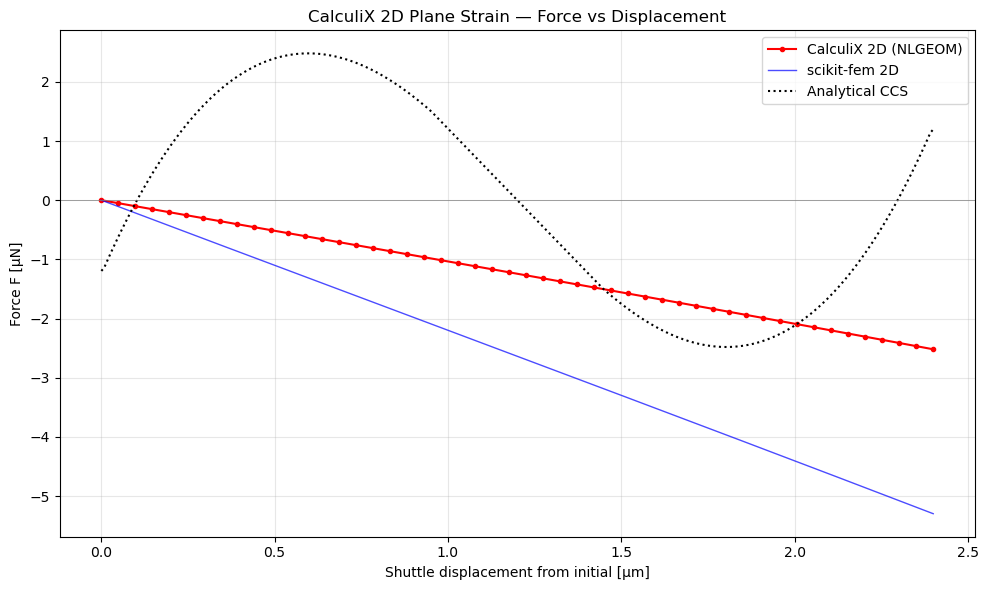

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(-delta_ccx, F_ccx, 'ro-', linewidth=1.5, ms=3, label='CalculiX 2D (NLGEOM)')

# Overlay other results
try:
    data = np.loadtxt('results/skfem_2d_force_displacement.csv',
                      delimiter=',', skiprows=1)
    ax.plot(data[:, 0], data[:, 1], 'b-', linewidth=1, alpha=0.7,
            label='scikit-fem 2D')
except FileNotFoundError:
    pass

try:
    ana = np.loadtxt('results/analytical_force_displacement.csv',
                     delimiter=',', skiprows=1)
    ax.plot(ana[:, 0], ana[:, 2], 'k:', linewidth=1.5, label='Analytical CCS')
except FileNotFoundError:
    pass

ax.axhline(0, color='gray', linewidth=0.5)
ax.set_xlabel('Shuttle displacement from initial [µm]')
ax.set_ylabel('Force F [µN]')
ax.set_title('CalculiX 2D Plane Strain — Force vs Displacement')
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig('plots/calculix_2d_force_displacement.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Save results
np.savetxt('results/calculix_2d_force_displacement.csv',
           np.column_stack([-delta_ccx, F_ccx]),
           delimiter=',',
           header='delta_um,F_uN',
           comments='')

print("Saved: results/calculix_2d_force_displacement.csv")

Saved: results/calculix_2d_force_displacement.csv


## 7. Deformed Shapes and Stress (from .frd output)

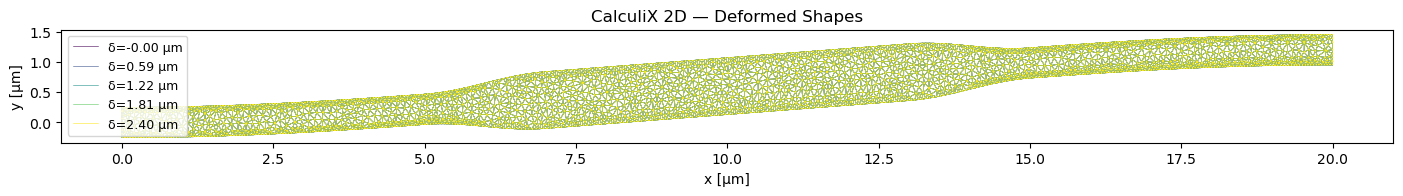

In [10]:
def parse_ccx_frd_displacements(frd_file, n_nodes):
    """Parse nodal displacements from CalculiX .frd binary/ASCII output.
    
    Returns (ux, uy) arrays.
    """
    ux = np.zeros(n_nodes)
    uy = np.zeros(n_nodes)
    
    with open(frd_file, 'r') as f:
        lines = f.readlines()
    
    # Find DISP block
    in_disp = False
    for line in lines:
        if 'DISP' in line or 'DISPR' in line:
            in_disp = True
            continue
        if in_disp:
            if line.startswith(' -3'):
                # End of block
                break
            if line.startswith(' -1'):
                # Node data line: " -1    nid    ux    uy    uz"
                parts = line.split()
                try:
                    nid = int(parts[1]) - 1  # to 0-indexed
                    if 0 <= nid < n_nodes:
                        ux[nid] = float(parts[2])
                        uy[nid] = float(parts[3])
                except (IndexError, ValueError):
                    continue
    
    return ux, uy

# Plot deformed shapes at a few key steps
fig, ax = plt.subplots(figsize=(14, 5))
ax.triplot(nodes[:, 0], nodes[:, 1], elems, 'k-', alpha=0.1, linewidth=0.3)

key_steps = [0, n_ccx_steps//4, n_ccx_steps//2, 3*n_ccx_steps//4, n_ccx_steps-1]
colors = plt.cm.viridis(np.linspace(0, 1, len(key_steps)))

for k, step_idx in enumerate(key_steps):
    frd_file = os.path.join(CCX_DIR, f'step_{step_idx:03d}.frd')
    if os.path.exists(frd_file):
        ux, uy = parse_ccx_frd_displacements(frd_file, len(nodes))
        ax.triplot(nodes[:, 0] + ux, nodes[:, 1] + uy, elems,
                   '-', color=colors[k], linewidth=0.4,
                   label=f'δ={-delta_ccx[step_idx]:.2f} µm')

ax.set_aspect('equal')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.set_title('CalculiX 2D — Deformed Shapes')
ax.legend(fontsize=9)
fig.tight_layout()
fig.savefig('plots/calculix_2d_deformed_shapes.png', dpi=150, bbox_inches='tight')
plt.show()